In [14]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
import jax.scipy.special as jss
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive, init_to_value

In [2]:
def np_logit(p):
    return np.log(p) - np.log(1-p)

def np_expit(p):
    return np.exp(p) / (1 + np.exp(p))

In [2]:
data = pd.read_csv('../data/ME2QOLData.csv')
data.head()

,patient,dose,time,QOL
0,1,0,4,2
1,1,0,8,2
2,1,0,12,1
3,1,0,16,2
4,1,0,20,2


In [4]:
data.describe()

,patient,dose,time,QOL
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,250.500000,20.000000,14.000000,2.136000
std,144.361341,20.003334,6.832439,0.701666
min,1.000000,0.000000,4.000000,1.000000
25%,125.750000,0.000000,8.000000,2.000000
50%,250.500000,20.000000,14.000000,2.000000
75%,375.250000,40.000000,20.000000,3.000000
max,500.000000,40.000000,24.000000,3.000000


In [4]:
sum_data = data.groupby(['dose', 'time', 'QOL']).agg('count').reset_index()
sum_data['frac'] = sum_data['patient'] / 250
sum_data

,dose,time,QOL,patient,frac
0,0,4,1,52,0.208
1,0,4,2,124,0.496
2,0,4,3,74,0.296
3,0,8,1,43,0.172
4,0,8,2,116,0.464
5,0,8,3,91,0.364
6,0,12,1,52,0.208
7,0,12,2,117,0.468
8,0,12,3,81,0.324
9,0,16,1,49,0.196


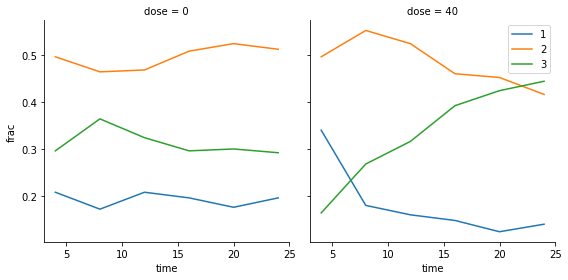

In [5]:
fig = sns.FacetGrid(data=sum_data, col='dose', hue='QOL', height=4)
fig.map(sns.lineplot, 'time', 'frac')
plt.legend()

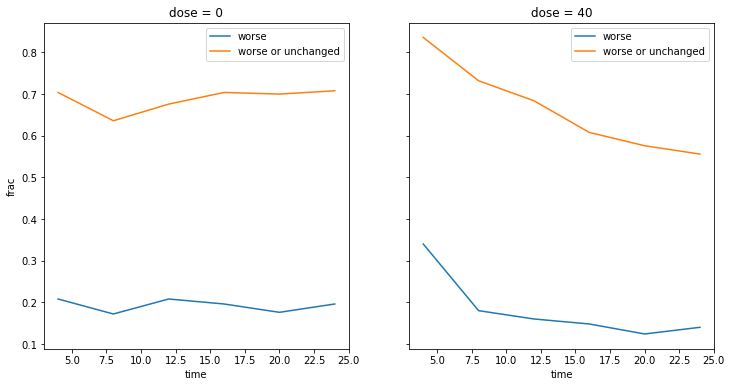

In [6]:
sub1 = data[data['QOL']==1].groupby(['dose','time']).agg('count').reset_index()
sub1['frac'] = sub1['patient'] / 250

sub2 = data[data['QOL']<=2].groupby(['dose','time']).agg('count').reset_index()
sub2['frac'] = sub2['patient'] / 250

_, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.lineplot(data=sub1[sub1['dose']==0], x='time', y='frac', ax=ax[0], label='worse')
sns.lineplot(data=sub1[sub1['dose']==40], x='time', y='frac', ax=ax[1], label='worse')
sns.lineplot(data=sub2[sub2['dose']==0], x='time', y='frac', ax=ax[0], label='worse or unchanged')
sns.lineplot(data=sub2[sub2['dose']==40], x='time', y='frac', ax=ax[1], label='worse or unchanged')
plt.legend()
ax[0].title.set_text('dose = 0')
ax[1].title.set_text('dose = 40')

In [9]:
sub1['frac'].apply(np_logit)


0    -1.337023
1    -1.571519
2    -1.337023
3    -1.411485
4    -1.543687
5    -1.411485
6    -0.663294
7    -1.516347
8    -1.658228
9    -1.750374
10   -1.955085
11   -1.815290
Name: frac, dtype: float64

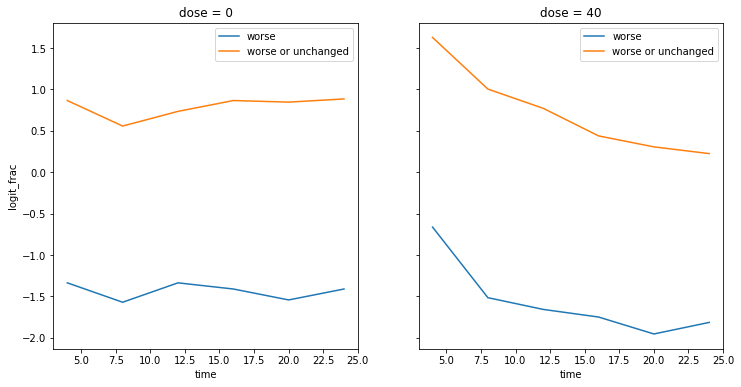

In [7]:
sub1['logit_frac'] = sub1['frac'].apply(np_logit)
sub2['logit_frac'] = sub2['frac'].apply(np_logit)

_, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.lineplot(data=sub1[sub1['dose']==0], x='time', y='logit_frac', ax=ax[0], label='worse')
sns.lineplot(data=sub1[sub1['dose']==40], x='time', y='logit_frac', ax=ax[1], label='worse')
sns.lineplot(data=sub2[sub2['dose']==0], x='time', y='logit_frac', ax=ax[0], label='worse or unchanged')
sns.lineplot(data=sub2[sub2['dose']==40], x='time', y='logit_frac', ax=ax[1], label='worse or unchanged')
plt.legend()
ax[0].title.set_text('dose = 0')
ax[1].title.set_text('dose = 40')

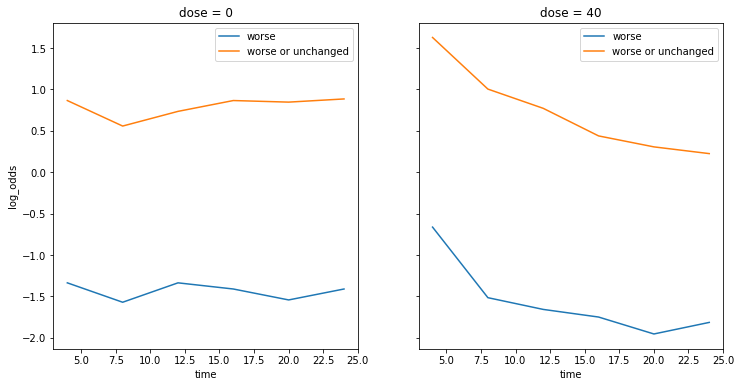

In [8]:
sub1['odds'] = sub1['frac'].apply(lambda x: x/(1-x))
sub1['log_odds'] = sub1['odds'].apply(np.log)
sub2['odds'] = sub2['frac'].apply(lambda x: x/(1-x))
sub2['log_odds'] = sub2['odds'].apply(np.log)

_, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.lineplot(data=sub1[sub1['dose']==0], x='time', y='log_odds', ax=ax[0], label='worse')
sns.lineplot(data=sub1[sub1['dose']==40], x='time', y='log_odds', ax=ax[1], label='worse')
sns.lineplot(data=sub2[sub2['dose']==0], x='time', y='log_odds', ax=ax[0], label='worse or unchanged')
sns.lineplot(data=sub2[sub2['dose']==40], x='time', y='log_odds', ax=ax[1], label='worse or unchanged')
plt.legend()
ax[0].title.set_text('dose = 0')
ax[1].title.set_text('dose = 40')

### Proposed Model
Cumulative logit model for the HRQOL score on the $i^{th}$ visit of the $j^{th}$ patient:

$$QOL_{ij} \sim Categorical(p_{ij})$$
$$p_{m,ij} = Pr(QOL_{ij} = m), m \in \{1, 2, 3\}$$
$$p_{m,ij} = Pr(QOL_{ij} ≤ m) - Pr(QOL_{ij} ≤ m-1)$$

$$logit(Pr(QOL_{ij}≤m)) = \alpha_m - (E_{placebo,ij} + E_{drug,ij}) + \epsilon_j$$

$$E_{placebo,ij} = \beta * t_{ij}$$
$$E_{drug,ij} = I_{Dose_j>0} (a + b * (1 - e^{-kt_{ij}}))$$
$$\epsilon_j \sim Normal(0, \sigma^2)$$

Priors:

$$\alpha_1 \sim Normal(0, 10^6)$$
$$\alpha_2 - \alpha_1 \sim truncatedNormal(0, 10^6), \alpha_2 - \alpha_1 > 0$$
$$\beta \sim Normal(0, 10^6)$$
$$a \sim Normal(0, 10^6)$$
$$b \sim Normal(0, 10^6)$$
$$k \sim LogNormal(0, 10^6)$$
$$\sigma \sim Uniform(0, 10^4)$$

In [3]:
# data to analysis
n_ptt = data['patient'].unique().shape[0]
ind_ptt = data['patient'].values - 1

time = data['time'].values

drug = np.array([1  if i>0 else 0 for i in data['dose']])

qol = data['QOL'].values - 1

In [17]:
def model(obs=None):
    # priors
    alpha = numpyro.sample('alpha', 
                dist.TransformedDistribution(
                    base_distribution=dist.Normal(0,2).expand([2]),
                    transforms=dist.transforms.OrderedTransform()
                ))
    
    beta = numpyro.sample('beta', dist.Normal(0, 1))
    a = numpyro.sample('a', dist.Normal(0, 1))
    b = numpyro.sample('b', dist.Normal(0, 2))
    k = numpyro.sample('k', dist.LogNormal(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 1))

    # likelihood
    with numpyro.plate('ptt_plate', size=n_ptt):
        epsilon = numpyro.sample('epsilon', dist.Normal(0, sigma))
    with numpyro.plate('obs', size=len(drug)):
        ## drug effect
        e_drug = numpyro.deterministic('e_drug', drug * (a + b * (1 - jnp.exp(-k * time))))
        ## placebo effect
        e_placebo = numpyro.deterministic('e_placebo', beta * time)

        phi = numpyro.deterministic('phi',e_placebo + e_drug + epsilon[ind_ptt])

        numpyro.sample('qol', dist.OrderedLogistic(predictor=phi, cutpoints=alpha), obs=qol)
init_values ={
    'alpha': jnp.array([-2.,2.])
}
kernel = NUTS(model, init_strategy=numpyro.infer.init_to_value(values=init_values))
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2, chain_method='sequential')
mcmc.run(random.PRNGKey(31), obs=qol)

sample: 100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s, 1023 steps of size 1.18e-04. acc. prob=0.83]


In [18]:
vars = ['alpha', 'beta', 'a', 'b', 'k', 'sigma']
az.summary(mcmc, vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-3.224,1.104,-4.332,-2.119,0.774,0.654,2.0,11.0,2.60
alpha[1],-0.834,1.388,-2.234,0.561,0.973,0.822,3.0,15.0,2.39
beta,0.147,0.217,-0.074,0.385,0.152,0.128,3.0,11.0,2.28
a,0.405,1.933,-1.529,2.345,1.356,1.145,3.0,12.0,2.27
b,-0.731,0.996,-1.728,0.271,0.699,0.590,3.0,11.0,2.03
k,0.169,0.146,0.024,0.315,0.102,0.086,3.0,16.0,2.32
sigma,0.832,0.168,0.663,1.000,0.118,0.100,2.0,17.0,2.91


In [33]:
init_values ={
    'alpha': jnp.array([-2.,1.])
}
def model(drug, obs=None):
    # priors
    alpha = numpyro.sample('alpha', 
                dist.TransformedDistribution(
                    base_distribution=dist.Uniform(-2,2).expand([2]),
                    transforms=dist.transforms.OrderedTransform()
                ))
    
    beta = numpyro.sample('beta', dist.Normal(0, 5))
    e_placebo = numpyro.sample('e_placebo', dist.Normal(0, 5))
    # a = numpyro.sample('a', dist.Normal(0, 1))
    # b = numpyro.sample('b', dist.Normal(0, 2))
    # k = numpyro.sample('k', dist.LogNormal(0, 1))
    # sigma = numpyro.sample('sigma', dist.Uniform(0, 1))

    # likelihood
    # with numpyro.plate('ptt_plate', size=n_ptt):
    #     epsilon = numpyro.sample('epsilon', dist.Normal(0, sigma))
    with numpyro.plate('obs', size=len(drug)):
        # ## drug effect
        # e_drug = numpyro.deterministic('e_drug', drug * (a + b * (1 - jnp.exp(-k * time))))
        # ## placebo effect
        # e_placebo = numpyro.deterministic('e_placebo', beta * time)

        # phi = numpyro.deterministic('phi',e_placebo + e_drug + epsilon[ind_ptt])
        phi = e_placebo + beta*drug

        numpyro.sample('qol', dist.OrderedLogistic(predictor=phi, cutpoints=alpha), obs=qol)

kernel = NUTS(model, init_strategy=numpyro.infer.init_to_value(values=init_values))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=5, num_chains=3, chain_method='sequential')
mcmc.run(random.PRNGKey(123), drug, obs=qol)
az.summary(mcmc)

sample: 100%|██████████| 3000/3000 [05:03<00:00,  9.87it/s, 1023 steps of size 3.58e-04. acc. prob=0.81]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-3.195,0.965,-4.561,-2.382,0.551,0.434,4.0,17.0,2.58
alpha[1],-0.643,0.345,-1.212,-0.334,0.196,0.155,4.0,12.0,2.49
beta,0.386,0.593,-0.223,1.221,0.339,0.267,4.0,11.0,2.90
e_placebo,0.566,0.311,0.229,1.024,0.178,0.140,3.0,11.0,3.20


array([[<AxesSubplot:title={'center':'alpha\n0'}>,
        <AxesSubplot:title={'center':'alpha\n0'}>],
       [<AxesSubplot:title={'center':'alpha\n1'}>,
        <AxesSubplot:title={'center':'alpha\n1'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'e_placebo'}>,
        <AxesSubplot:title={'center':'e_placebo'}>]], dtype=object)

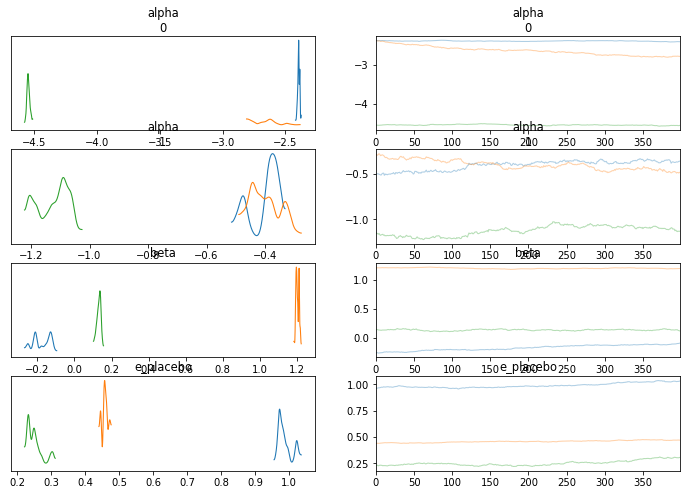

In [34]:
az.plot_trace(mcmc, compact=False)

sample: 100%|██████████| 3000/3000 [00:00<00:00, 17065.93it/s, 3 steps of size 6.00e-01. acc. prob=0.92] 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.505,0.066,-1.622,-1.377,0.002,0.002,942.0,1091.0,1.01
alpha[1],0.687,0.052,0.592,0.787,0.001,0.001,1237.0,1088.0,1.00


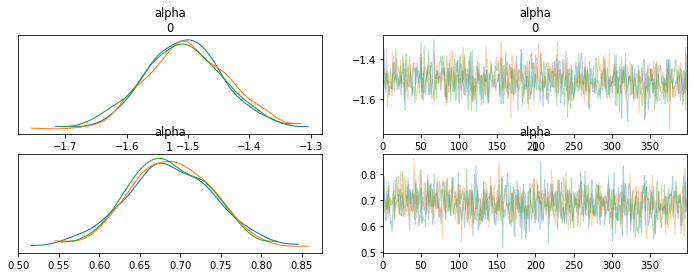

In [39]:
qol = data[data['dose']==40]['QOL'].values - 1
init_values ={
    'alpha': jnp.array([-2.,1.])
}
def model(drug, obs=None):
    # priors
    alpha = numpyro.sample('alpha', 
                dist.TransformedDistribution(
                    base_distribution=dist.Normal(0,10).expand([2]),
                    transforms=dist.transforms.OrderedTransform()
                ))

    # likelihood
    numpyro.sample('qol', dist.OrderedLogistic(predictor=0, cutpoints=alpha), obs=qol)

kernel = NUTS(model, init_strategy=numpyro.infer.init_to_value(values=init_values))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=5, num_chains=3, chain_method='sequential')
mcmc.run(random.PRNGKey(123), drug, obs=qol)
az.plot_trace(mcmc, compact=False)
az.summary(mcmc)

sample: 100%|██████████| 3000/3000 [00:13<00:00, 226.57it/s, 255 steps of size 3.21e-02. acc. prob=0.94]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.655,1.151,-1.501,2.812,0.035,0.027,1080.0,958.0,1.0
alpha[1],2.948,1.155,0.714,5.053,0.035,0.025,1081.0,933.0,1.0
a,-0.003,1.022,-1.756,1.924,0.031,0.022,1119.0,1085.0,1.0
b,2.708,0.510,1.907,3.739,0.015,0.011,1120.0,1061.0,1.0
k,0.170,0.051,0.080,0.263,0.002,0.001,1078.0,1094.0,1.0


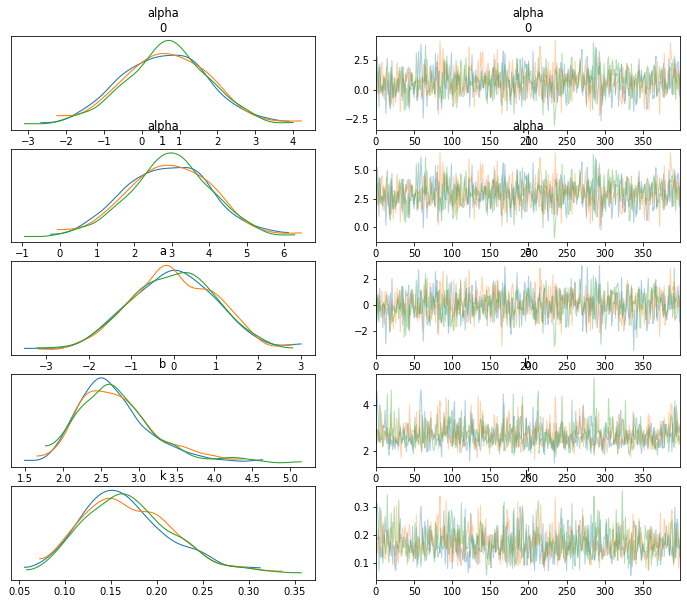

In [43]:
qol = data[data['dose']==40]['QOL'].values - 1
time = data[data['dose']==40]['time'].values

init_values ={
    'alpha': jnp.array([-2.,1.])
}
def model(time, obs=None):
    # priors
    alpha = numpyro.sample('alpha', 
                dist.TransformedDistribution(
                    base_distribution=dist.Normal(0,10).expand([2]),
                    transforms=dist.transforms.OrderedTransform()
                ))
    a = numpyro.sample('a', dist.Normal(0, 1))
    b = numpyro.sample('b', dist.Normal(0, 2))
    k = numpyro.sample('k', dist.LogNormal(0, 1))

    # likelihood
    e_drug = numpyro.deterministic('e_drug', a + b * (1 - jnp.exp(-k * time)))
    numpyro.sample('qol', dist.OrderedLogistic(predictor=e_drug, cutpoints=alpha), obs=qol)

kernel = NUTS(model, init_strategy=numpyro.infer.init_to_value(values=init_values))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=5, num_chains=3, chain_method='sequential')
mcmc.run(random.PRNGKey(123), time, obs=qol)
vars = ['alpha', 'a', 'b', 'k']
az.plot_trace(mcmc, vars, compact=False)
az.summary(mcmc, vars)

sample: 100%|██████████| 3000/3000 [00:00<00:00, 5934.20it/s, 15 steps of size 2.69e-01. acc. prob=0.52]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.507,0.064,-1.629,-1.393,0.004,0.003,214.0,362.0,1.03
alpha[1],0.681,0.059,0.588,0.804,0.003,0.002,333.0,286.0,1.02
a,-0.070,1.031,-1.982,1.928,0.063,0.045,267.0,568.0,1.02
b,-0.118,1.948,-3.483,3.703,0.104,0.074,355.0,631.0,1.01
k,1.726,1.944,0.025,5.100,0.163,0.116,174.0,177.0,1.02


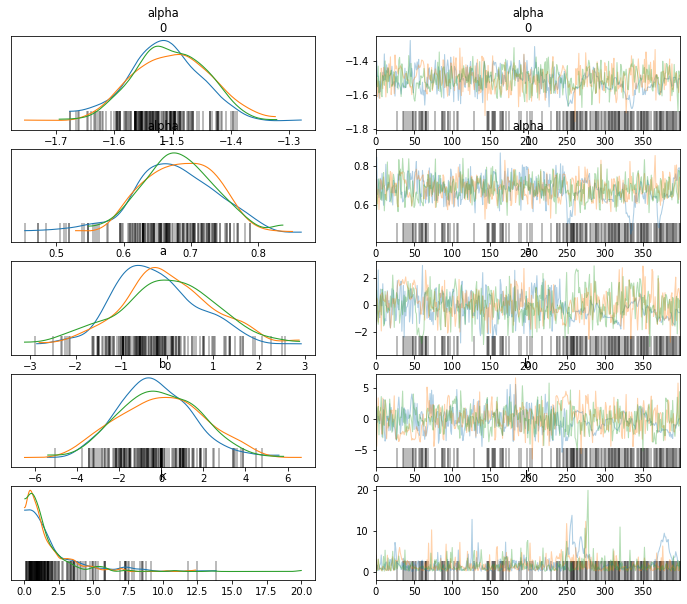

In [46]:

qol = data[data['dose']==40]['QOL'].values - 1
time = data[data['dose']==40]['time'].values
n_ptt = data[data['dose']==40]['patient'].unique().shape[0]
ind_ptt = pd.Categorical(data[data['dose']==40]['patient']).codes

init_values ={
    'alpha': jnp.array([-2.,1.])
}
def model(n_ptt, ind_ptt, time, obs=None):
    # priors
    alpha = numpyro.sample('alpha', 
                dist.TransformedDistribution(
                    base_distribution=dist.Normal(0,10).expand([2]),
                    transforms=dist.transforms.OrderedTransform()
                ))
    a = numpyro.sample('a', dist.Normal(0, 1))
    b = numpyro.sample('b', dist.Normal(0, 2))
    k = numpyro.sample('k', dist.LogNormal(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 1))

    # likelihood
    with numpyro.plate('ptt_plate', size=n_ptt):
        epsilon = numpyro.sample('epsilon', dist.Normal(0, sigma))
    e_drug = numpyro.deterministic('e_drug', a + b * (1 - jnp.exp(-k * time))+ epsilon[ind_ptt])
    numpyro.sample('qol', dist.OrderedLogistic(predictor=0, cutpoints=alpha), obs=qol)

kernel = NUTS(model, init_strategy=numpyro.infer.init_to_value(values=init_values))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=5, num_chains=3, chain_method='sequential')
mcmc.run(random.PRNGKey(123), n_ptt, ind_ptt, time, obs=qol)
vars = ['alpha', 'a', 'b', 'k']
az.plot_trace(mcmc, vars, compact=False)
az.summary(mcmc, vars)

In [44]:
pd.Categorical(data[data['dose']==40]['patient']).codes

array([  0,   0,   0, ..., 249, 249, 249], dtype=int16)